# Flash drought decomposition projections results

In [2]:
import glob as glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import sys
import os
import numpy as np
import time
import zarr
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/g/data/mn51/users/jb6465/code/flash-drought/attribution-python')
from attribution import *
from plotting import *
from extract import *

In [4]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger("distributed.shuffle._scheduler_plugin").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)
np_divide_error = np.seterr(invalid='ignore')

In [5]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb") #"252000mb") #larger memory required to compute ET0/sensitvities, smaller for plotting/analysis
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45261/status,
Dashboard: /proxy/45261/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41177,Workers: 0
Dashboard: /proxy/45261/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45319,Total threads: 1
Dashboard: /proxy/46085/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:33847,


2025-12-18 16:23:24,006 - distributed.scheduler - WARNING - Worker failed to heartbeat for 304s; attempting restart: <WorkerState 'tcp://127.0.0.1:34169', name: 1, status: running, memory: 0, processing: 0>
2025-12-18 16:23:24,067 - distributed.scheduler - WARNING - Worker failed to heartbeat for 304s; attempting restart: <WorkerState 'tcp://127.0.0.1:35415', name: 8, status: running, memory: 0, processing: 0>
2025-12-18 16:23:24,068 - distributed.scheduler - WARNING - Worker failed to heartbeat for 304s; attempting restart: <WorkerState 'tcp://127.0.0.1:38093', name: 5, status: running, memory: 0, processing: 0>
2025-12-18 16:23:24,069 - distributed.scheduler - WARNING - Worker failed to heartbeat for 304s; attempting restart: <WorkerState 'tcp://127.0.0.1:38189', name: 9, status: running, memory: 0, processing: 0>
2025-12-18 16:23:24,070 - distributed.scheduler - WARNING - Worker failed to heartbeat for 304s; attempting restart: <WorkerState 'tcp://127.0.0.1:38217', name: 2, status: 

## Compute $ET_0$ (projections)

In [10]:
sys.path.append('/g/data/mn51/users/jb6465/code/hazard-drought-exp/submodules/dataset_finder')
from dataset_finder import *

In [11]:
%%time
ACS_downscaled_historical = get_datasets("NHP", scenario = "historical" , timescale='day', var=['sfcWindAdjust', 'tasAdjust', 'tasmaxAdjust', 'tasminAdjust', 'rsdsAdjust', 'hussAdjust', 'psAdjust'], grid=("AUST-05i"))
ACS_downscaled_ssp370 = get_datasets("NHP", scenario = "ssp370" , timescale='day', var=['sfcWindAdjust', 'tasAdjust', 'tasmaxAdjust', 'tasminAdjust', 'rsdsAdjust', 'hussAdjust', 'psAdjust'], grid=("AUST-05i"))
ACS_downscaled_ssp126 = get_datasets("NHP", scenario = "ssp126" , timescale='day', var=['sfcWindAdjust', 'tasAdjust', 'tasmaxAdjust', 'tasminAdjust', 'rsdsAdjust', 'hussAdjust', 'psAdjust'], grid=("AUST-05i"))

CPU times: user 1.67 s, sys: 261 ms, total: 1.94 s
Wall time: 2.25 s


In [12]:
ACS_downscaled_historical

,grid,org,gcm,scenario,mdl_run,rcm,ver,bc_org,bc,ref,bc_period,timescale,,var,date_created,year
0,AUST-05i,BOM,ACCESS-CM2,historical,r4i1p1f1,BARPA-R,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
1,AUST-05i,BOM,ACCESS-ESM1-5,historical,r6i1p1f1,BARPA-R,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
2,AUST-05i,BOM,CESM2,historical,r11i1p1f1,BARPA-R,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
3,AUST-05i,BOM,CMCC-ESM2,historical,r1i1p1f1,BARPA-R,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
4,AUST-05i,BOM,EC-Earth3,historical,r1i1p1f1,BARPA-R,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
5,AUST-05i,BOM,MPI-ESM1-2-HR,historical,r1i1p1f1,BARPA-R,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
6,AUST-05i,BOM,NorESM2-MM,historical,r1i1p1f1,BARPA-R,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
7,AUST-05i,CSIRO,ACCESS-CM2,historical,r4i1p1f1,CCAM-v2203-SN,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
8,AUST-05i,CSIRO,ACCESS-ESM1-5,historical,r6i1p1f1,CCAM-v2203-SN,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014
9,AUST-05i,CSIRO,CESM2,historical,r11i1p1f1,CCAM-v2203-SN,v1-r1,NHP,MRNBC,BARRAR2,1980-2022,day,,"hussAdjust, psAdjust, rsdsAdjust, sfcWindAdjust, tasAdjust, tasmaxAdjust, tasminAdjust",v20250311,1960 to 2014


In [18]:
%%time
#compute ET0 and sensitivities ~ fastest and least memory intensive to create annual zarr files using dask
scenario_files = {'historical':ACS_downscaled_historical, 'ssp370':ACS_downscaled_ssp370, 'ssp126':ACS_downscaled_ssp126}
scen_input = 'historical'
save_dir = '/g/data/mn51/users/jb6465/data/flash_drought/projections'
for ens_idx in range(0,14):
    #get info for save string
    GCM = str(scenario_files[scen_input][ens_idx]).split('\n')[3].split()[-1]
    variant = str(scenario_files[scen_input][ens_idx]).split('\n')[5].split()[-1]
    RCM = str(scenario_files[scen_input][ens_idx]).split('\n')[6].split()[-1]
    BC = str(scenario_files[scen_input][ens_idx]).split('\n')[8].split()[-1]+'_'+str(scenario_files[scen_input][ens_idx]).split('\n')[9].split()[-1]+'_'+str(scenario_files[scen_input][ens_idx]).split('\n')[10].split()[-1]
    scenario_years = {'historical':range(1960, 2015), 'ssp370':range(2015, 2101 if RCM == 'BARPA-R' else 2100), 'ssp126':range(2015,  2101 if RCM == 'BARPA-R' else 2100)}
        
    if not os.path.exists(f"{save_dir}/{GCM}_{variant}_{RCM}/{scen_input}/{scenario_years[scen_input][-1]}-{GCM}_{variant}_{RCM}_{BC}_ET0_tall_and_driver_sensitivities.zarr"):
        print(scenario_files[scen_input][ens_idx])
        
        #ingest inputs 
        Rs = xr.open_mfdataset(scenario_files[scen_input][ens_idx].select(var='rsdsAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4').rsdsAdjust
        T = xr.open_mfdataset(scenario_files[scen_input][ens_idx].select(var='tasAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4').tasAdjust
        Tmax = xr.open_mfdataset(scenario_files[scen_input][ens_idx].select(var='tasmaxAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4').tasmaxAdjust
        Tmin = xr.open_mfdataset(scenario_files[scen_input][ens_idx].select(var='tasminAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4').tasminAdjust
        Patm = xr.open_mfdataset(scenario_files[scen_input][ens_idx].select(var='psAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4').psAdjust
        Q2M = xr.open_mfdataset(scenario_files[scen_input][ens_idx].select(var='hussAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4').hussAdjust
        W10M = xr.open_mfdataset(scenario_files[scen_input][ens_idx].select(var='sfcWindAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4').sfcWindAdjust 
        elev = xr.open_dataset(glob.glob(f'/g/data/ia39/australian-climate-service/release/CORDEX/output-CMIP6/DD/AUST-05i/BOM/{GCM}/historical/{variant}/{RCM}/v1-r1/fx/orog/v20250311/*.nc')[0] if RCM == 'BARPA-R' else glob.glob(f'/g/data/ia39/australian-climate-service/release/CORDEX/output-CMIP6/DD/AUST-05i/CSIRO/{GCM}/historical/{variant}/{RCM}/v1-r1/fx/orog/v20250311/*.nc')[0]).orog

        # compute ET0 annually
        for year in scenario_years[scen_input]:
            if not os.path.exists(f"{save_dir}/{GCM}_{variant}_{RCM}/{scen_input}/{year}-{GCM}_{variant}_{RCM}_{BC}_ET0_tall_and_driver_sensitivities.zarr"):
                start = time.time()
                #compute ET0 and components
                ET0 = compute_and_decompose_ET0((Rs.chunk({'time':365, 'lat':'auto', 'lon':'auto'}).sel(time=str(year)))*86400,
                                                T.chunk({'time':365, 'lat':'auto', 'lon':'auto'}).sel(time=str(year)),
                                                Tmax.chunk({'time':365, 'lat':'auto', 'lon':'auto'}).sel(time=str(year)),
                                                Tmin.chunk({'time':365, 'lat':'auto', 'lon':'auto'}).sel(time=str(year)),
                                                None, #Tdew
                                                Patm.chunk({'time':365, 'lat':'auto', 'lon':'auto'}).sel(time=str(year)),
                                                W10M.chunk({'time':365, 'lat':'auto', 'lon':'auto'}).sel(time=str(year)),
                                                Q2M.chunk({'time':365, 'lat':'auto', 'lon':'auto'}).sel(time=str(year)), 
                                                None, None, None, #RH vars
                                                elev,
                                                derive_2m_windspeed=True, short_tall_crop_switch='tall', T2M_model_or_derived='derived', Patm_model_or_derived='model', esat_method='TmaxTmin', eact_method='Patm_q', Rnl_method='TmaxTmin')
                
                #save locally as a zarr file
                os.makedirs(f"{save_dir}/{GCM}_{variant}_{RCM}/{scen_input}/", exist_ok=True)
                xr.Dataset({"ET0_tall_crop": ET0}).reset_coords(drop=True).astype('float16').to_zarr(f"/g/data/mn51/users/jb6465/data/flash_drought/projections/{GCM}_{variant}_{RCM}/{scen_input}/{year}-{GCM}_{variant}_{RCM}_{BC}_ET0_tall.zarr", consolidated=True, encoding={"ET0_tall_crop": {"compressor": zarr.Blosc(cname='zstd', clevel=5, shuffle=1)}})
                
                end = time.time()
                print(f" ~ {year} computed in {end - start:.2f} s")
    else:
        print(f'--> {GCM}_{variant}_{RCM} for {scen_input} already computed in {save_dir}/{GCM}_{variant}_{RCM}/')

--> ACCESS-CM2_r4i1p1f1_BARPA-R for historical already computed in /g/data/mn51/users/jb6465/data/flash_drought/projections/ACCESS-CM2_r4i1p1f1_BARPA-R/
--> ACCESS-ESM1-5_r6i1p1f1_BARPA-R for historical already computed in /g/data/mn51/users/jb6465/data/flash_drought/projections/ACCESS-ESM1-5_r6i1p1f1_BARPA-R/
--> CESM2_r11i1p1f1_BARPA-R for historical already computed in /g/data/mn51/users/jb6465/data/flash_drought/projections/CESM2_r11i1p1f1_BARPA-R/
--> CMCC-ESM2_r1i1p1f1_BARPA-R for historical already computed in /g/data/mn51/users/jb6465/data/flash_drought/projections/CMCC-ESM2_r1i1p1f1_BARPA-R/
--> EC-Earth3_r1i1p1f1_BARPA-R for historical already computed in /g/data/mn51/users/jb6465/data/flash_drought/projections/EC-Earth3_r1i1p1f1_BARPA-R/
--> MPI-ESM1-2-HR_r1i1p1f1_BARPA-R for historical already computed in /g/data/mn51/users/jb6465/data/flash_drought/projections/MPI-ESM1-2-HR_r1i1p1f1_BARPA-R/
--> NorESM2-MM_r1i1p1f1_BARPA-R for historical already computed in /g/data/mn51/us

## $ET_0$ means and variabilities

In [5]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
mean_dict = {}
var_dict = {}

In [ ]:
%%time
for ens_member in os.listdir('/g/data/mn51/users/jb6465/data/flash_drought/projections/'):
    print(f'~ {ens_member}')
    ET0 = xr.open_mfdataset(glob.glob(f'/g/data/mn51/users/jb6465/data/flash_drought/projections/{ens_member}/historical/*.zarr'), concat_dim='time', combine='nested', chunks={'time': -1, 'lat': 'auto', 'lon': 'auto'}).ET0_tall_crop.sortby('time')
    ET0 = ET0.sel(time=ET0['time'].dt.year.isin(range(1980, 2015))) #need to use this format to avoid ccam cftime errors
    mean_dict[ens_member] = ((ET0.assign_coords(doy=ET0['time'].dt.dayofyear).groupby('doy').mean('time')).mean(dim='doy')).compute()
    var_dict[ens_member] = ((ET0.assign_coords(doy=ET0['time'].dt.dayofyear).groupby('doy').mean('time')).var(dim='doy')).compute()
    break

~ CESM2_r11i1p1f1_CCAM-v2203-SN


In [18]:
mean_dict = dict(sorted(mean_dict.items()))
var_dict = dict(sorted(var_dict.items()))

In [14]:
BARRA_ET0 = xr.open_mfdataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/*.nc').chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).ET0_tall_crop.sortby('time').sel(time=slice('1980', '2014'))
BARRA_ET0_mean = ((BARRA_ET0.assign_coords(doy=BARRA_ET0['time'].dt.dayofyear).groupby('doy').mean('time')).mean(dim='doy')).compute()
BARRA_ET0_var = ((BARRA_ET0.assign_coords(doy=BARRA_ET0['time'].dt.dayofyear).groupby('doy').mean('time')).var(dim='doy')).compute()

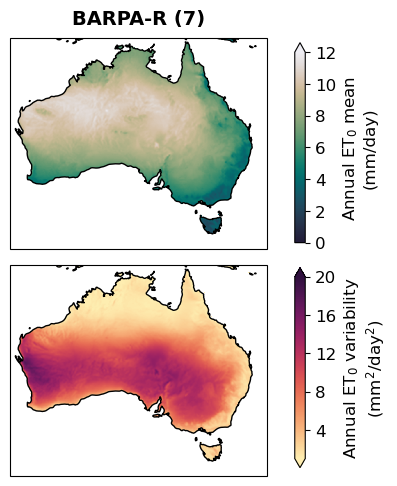

In [10]:
import cmocean

create_multiplot(nrows=2, ncols=1, plot_fontsize=12, title_size=14, figsize=(3.5, 5), plot_extent=[112, 156.2, -44, -10],
    plot_list=[[mask_ocean(xr.concat([v for k, v in mean_dict.items() if "BARPA-R" in k], dim="MME").median(dim='MME'))],
               [mask_ocean(xr.concat([v for k, v in var_dict.items() if "BARPA-R" in k], dim="MME").median(dim='MME'))]],
    shapefile = None,
    shapefile_linewidth = None,
    col_titles=['BARPA-R (7)'],
    col_titles_all_rows_switch=False,
    cmap_list=[cmocean.cm.rain_r, cmocean.cm.matter],
    cbar_labels=['Annual ET$_0$ mean\n(mm/day)', 'Annual ET$_0$ variability\n(mm$^2$/day$^2$)'],
    cbar_extensions=['max','both'],
    cbar_width=0.03,
    cbar_height = 0.4,
    cbar_nticks=[7, 5],
    cbar_x_y_loc = (0.92, 0.05 + 0.45),
    cbar_mins=[0,1],
    cbar_maxs=[12,20])


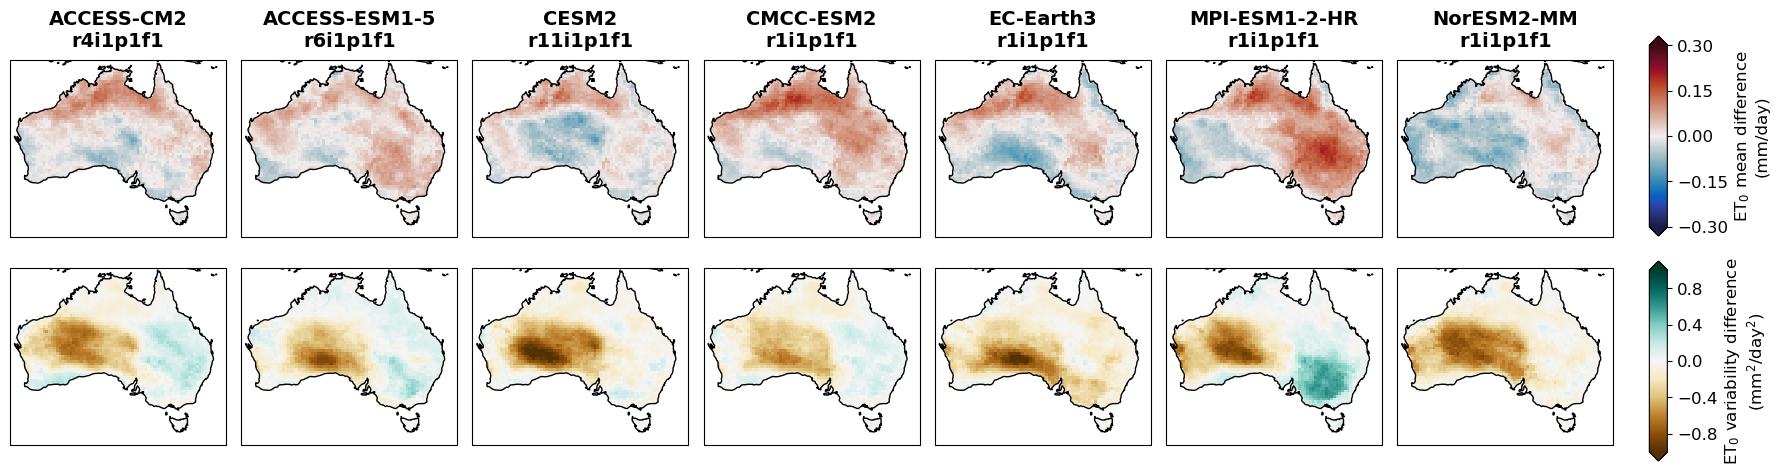

In [19]:
import cmocean

create_multiplot(nrows=2, ncols=7, plot_fontsize=12, title_size=14, figsize=(18, 5), plot_extent=[112, 156.2, -44, -10],
    plot_list=[[(mean_dict[k] - BARRA_ET0_mean) for k in mean_dict.keys() if "BARPA-R" in k],
               [(var_dict[k] - BARRA_ET0_var) for k in var_dict.keys() if "BARPA-R" in k]],
    shapefile = None,
    shapefile_linewidth = None,
    col_titles=[title.replace('_'+title.split('_')[-1],'').replace('_','\n') for title in list(mean_dict.keys()) if "BARPA-R" in title],
    col_titles_all_rows_switch=False,
    cmap_list=[cmocean.cm.balance, plt.cm.BrBG],
    cbar_labels=['ET$_0$ mean difference\n(mm/day)', 'ET$_0$ variability difference\n(mm$^2$/day$^2$)'],
    cbar_extensions=['both','both'],
    cbar_width=0.01,
    cbar_height = 0.4,
    cbar_nticks=[5,5],
    cbar_x_y_loc = (0.92, 0.05 + 0.45),
    cbar_mins=[-0.3,-1],
    cbar_maxs=[0.3,1])


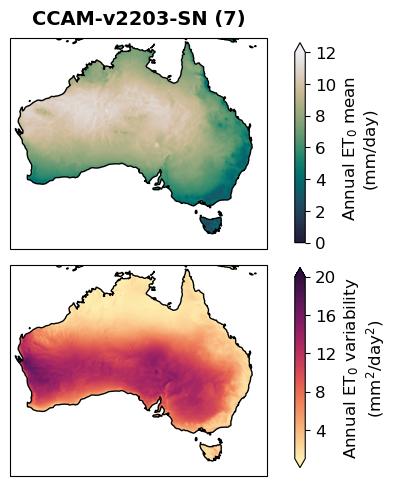

In [12]:
import cmocean

create_multiplot(nrows=2, ncols=1, plot_fontsize=12, title_size=14, figsize=(3.5, 5), plot_extent=[112, 156.2, -44, -10],
    plot_list=[[mask_ocean(xr.concat([v for k, v in mean_dict.items() if "CCAM" in k], dim="MME").median(dim='MME'))],
               [mask_ocean(xr.concat([v for k, v in var_dict.items() if "CCAM" in k], dim="MME").median(dim='MME'))]],
    shapefile = None,
    shapefile_linewidth = None,
    col_titles=['CCAM-v2203-SN (7)'],
    col_titles_all_rows_switch=False,
    cmap_list=[cmocean.cm.rain_r, cmocean.cm.matter],
    cbar_labels=['Annual ET$_0$ mean\n(mm/day)', 'Annual ET$_0$ variability\n(mm$^2$/day$^2$)'],
    cbar_extensions=['max','both'],
    cbar_width=0.03,
    cbar_height = 0.4,
    cbar_nticks=[7,5],
    cbar_mins=[0,1],
    cbar_maxs=[12,20])


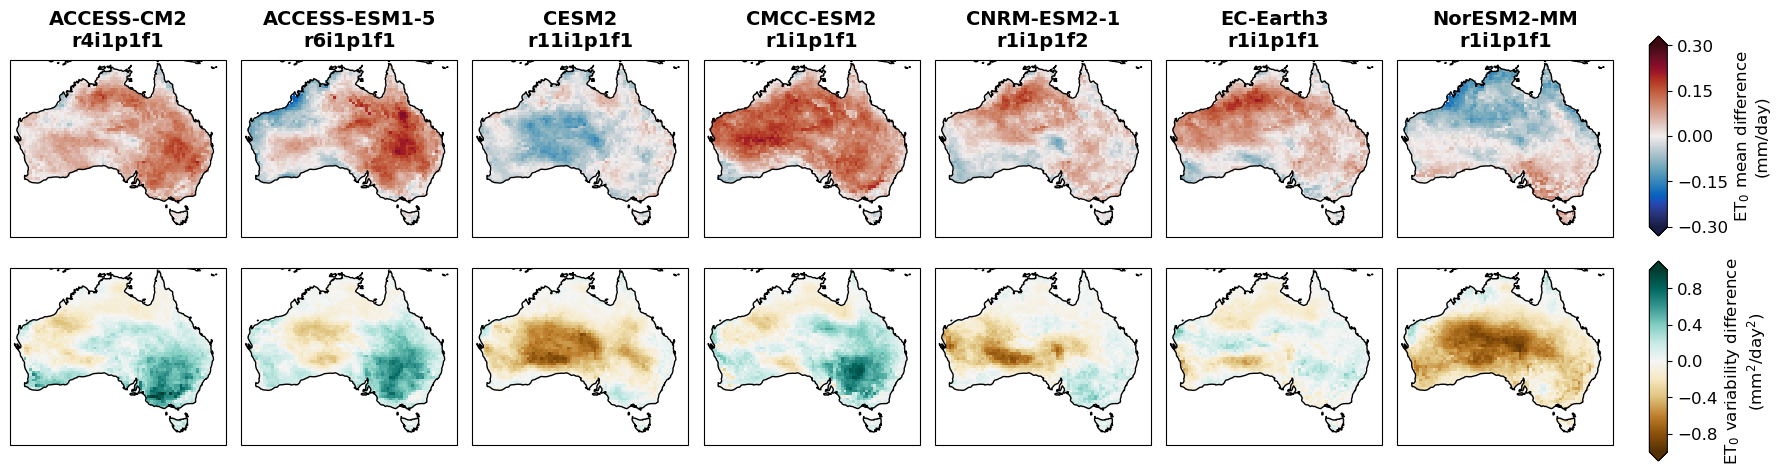

In [42]:
import cmocean

create_multiplot(nrows=2, ncols=7, plot_fontsize=12, title_size=14, figsize=(18, 5), plot_extent=[112, 156.2, -44, -10],
    plot_list=[[(mean_dict[k] - BARRA_ET0_mean) for k in mean_dict.keys() if "CCAM" in k],
               [(var_dict[k] - BARRA_ET0_var) for k in var_dict.keys() if "CCAM" in k]],
    shapefile = None,
    shapefile_linewidth = None,
    col_titles=[title.replace('_'+title.split('_')[-1],'').replace('_','\n') for title in list(mean_dict.keys()) if "CCAM" in title],
    col_titles_all_rows_switch=False,
    cmap_list=[cmocean.cm.balance, plt.cm.BrBG],
    cbar_labels=['ET$_0$ mean difference\n(mm/day)', 'ET$_0$ variability difference\n(mm$^2$/day$^2$)'],
    cbar_extensions=['both','both'],
    cbar_width=0.01,
    cbar_height = 0.4,
    cbar_nticks=[5,5],
    cbar_x_y_loc = (0.92, 0.05 + 0.45),
    cbar_mins=[-0.3,-1],
    cbar_maxs=[0.3,1])


## $ET_0$ driver sensitivities

In [21]:
sys.path.append('/g/data/mn51/users/jb6465/code/drought-github/submodules/gwls')
from gwl import *

In [73]:
def fix_cftime(ds):
    return ds.assign_coords(time=pd.to_datetime(ds.time.values.astype(str)))

for ens_idx in range(1,14):
    #get info for save string
    GCM = str(ACS_downscaled_historical[ens_idx]).split('\n')[3].split()[-1]
    variant = str(ACS_downscaled_historical[ens_idx]).split('\n')[5].split()[-1]
    RCM = str(ACS_downscaled_historical[ens_idx]).split('\n')[6].split()[-1]
    BC = str(ACS_downscaled_historical[ens_idx]).split('\n')[8].split()[-1]+'_'+str(ACS_downscaled_historical[ens_idx]).split('\n')[9].split()[-1]+'_'+str(ACS_downscaled_historical[ens_idx]).split('\n')[10].split()[-1]
            
    #ingest inputs 
    Rs = xr.open_mfdataset(ACS_downscaled_historical[ens_idx].select(var='rsdsAdjust').get_files()+ACS_downscaled_ssp370[0].select(var='rsdsAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4', preprocess=fix_cftime).rsdsAdjust
    T = 0.5* (xr.open_mfdataset(ACS_downscaled_historical[ens_idx].select(var='tasmaxAdjust').get_files()+ACS_downscaled_ssp370[0].select(var='tasmaxAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4', preprocess=fix_cftime).tasmaxAdjust + xr.open_mfdataset(ACS_downscaled_historical[ens_idx].select(var='tasminAdjust').get_files()+ACS_downscaled_ssp370[0].select(var='tasminAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4', preprocess=fix_cftime).tasminAdjust)
    q = xr.open_mfdataset(ACS_downscaled_historical[ens_idx].select(var='hussAdjust').get_files()+ACS_downscaled_ssp370[0].select(var='hussAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4', preprocess=fix_cftime).hussAdjust
    U = xr.open_mfdataset(ACS_downscaled_historical[ens_idx].select(var='sfcWindAdjust').get_files()+ACS_downscaled_ssp370[0].select(var='sfcWindAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4', preprocess=fix_cftime).sfcWindAdjust 
    Patm = xr.open_mfdataset(ACS_downscaled_historical[ens_idx].select(var='psAdjust').get_files()+ACS_downscaled_ssp370[0].select(var='psAdjust').get_files(), combine='nested', concat_dim='time', parallel = True, engine='netcdf4', preprocess=fix_cftime).psAdjust    
    elev = xr.open_dataset(glob.glob(f'/g/data/ia39/australian-climate-service/release/CORDEX/output-CMIP6/DD/AUST-05i/BOM/{GCM}/historical/{variant}/{RCM}/v1-r1/fx/orog/v20250311/*.nc')[0] if RCM == 'BARPA-R' else glob.glob(f'/g/data/ia39/australian-climate-service/release/CORDEX/output-CMIP6/DD/AUST-05i/CSIRO/{GCM}/historical/{variant}/{RCM}/v1-r1/fx/orog/v20250311/*.nc')[0]).orog

In [1]:
# %%time
# for gwl in [1.2, 1.5, 2.0, 3.0]:
#     R_climo = compute_doy_climo(compute_rolling_xday((Rs*86400).sel(time=Rs.time.dt.year.isin(range(syear, eyear+1))), 7, centre_window=True)).compute()
#     T_climo = compute_doy_climo(compute_rolling_xday((T-273.15).sel(time=T.time.dt.year.isin(range(syear, eyear+1))), 7, centre_window=True)).compute()
#     q_climo = compute_doy_climo(compute_rolling_xday(q.sel(time=q.time.dt.year.isin(range(syear, eyear+1))), 7, centre_window=True)).compute()
#     U_climo = compute_doy_climo(compute_rolling_xday(U.sel(time=U.time.dt.year.isin(range(syear, eyear+1))), 7, centre_window=True)).compute()
#     Patm_climo = compute_doy_climo(compute_rolling_xday(Patm.sel(time=Patm.time.dt.year.isin(range(syear, eyear+1))), 7, centre_window=True)).compute()
#     break

In [2]:
# %%time
# sens_T, sens_R, sens_q, sens_U = compute_driver_sensivities(R_climo,T_climo,U_climo,q_climo,Patm_climo,elev,
#                                                             short_tall_crop_switch = 'tall')